# Capstone: Trump vs Stock Market

# Modelling notebook

## Problem statement: 

The US market team at a local bank has seen literature on models that are able to predict market movement based on tweets by Donald Trump:
- [JP Morgan creating a 'Volfefe index to track tweets vs bond interest rates](https://www.marketwatch.com/story/are-trump-tweets-influencing-bond-volatility-jp-morgans-volfefe-index-aims-to-find-out-2019-09-09)
- [On days when President Trump tweets a lot, the stock market falls, Bank of America](https://www.cnbc.com/2019/09/03/on-days-when-president-trump-tweets-a-lot-the-stock-market-falls-investment-bank-finds.html)

They have tasked the data science team to build a classification model using Natural Language Processing to predict if Donald Trump's tweets are market moving. The models used are:
- Logistic Regression
- XGBoost
- Long Short Term Memory Neural Network
- Evaluate the models based on:
    - accuracy (% predictions the model gets correct, both a significant movement and a non-significant movement)
    - precision (% predicted significant movement when it is actually significant movement)
    - sensitivity (% predicted significant movement out of all correct predictions)
- choose the best performing model to test it on the holdout csv

## Data dictionary

### df_tweets
| Feature     	| Type 	| Description|                                                  
|:------------------	|:----------	|:----------------------------------------------------------------------------------|
| content	| object | Raw tweets from therealdonaldtrump |
| date	| object | Date of his tweet. YYYY-MM-DD-HH-MM-SS format |
| retweets	| int64 | Number of retweets by others at the time of data collection |
| favorites	| int64 | Number of favourites at the time of data collection |
| cleaned_tweets | object | Pre-processed tweets |
| tweet_day	| datetime64[ns] | Date of tweet YYYY-MM-DD format |
| month_sin	| float64 | Cycial sin month feature engineered. Range of -1 to 1 |
| month_cos	| float64 | Cycical cosine month feature engineered. Range of -1 to 1 |
| day_sin	| float64 | Cycical sin day feature engineered. Range of -1 to 1 |
| day_cos	| float64 | Cycical cosine day feature engineered. Range of -1 to 1 |
| hour_sin	| float64 | Cycical sin hour feature engineered. Range of -1 to 1 |
| hour_cos	| float64 | Cycical cosine hour feature engineered. Range of -1 to 1 |
| min_sin	| float64 | Cycical sin min feature engineered. Range of -1 to 1 |
| min_cos	| float64 | Cycical cosine min feature engineered. Range of -1 to 1 |
| time_to_open	| float64 | Time before the stock market opens on that day. In seconds | 	
| time_after_close	| float64 | Time after the stock market closes on that day. In seconds |	
| potus_status	| int64 | President of the United States status |
| vader_negative	| float64 | Negative sentiment analysis using Vader. Scale of 0 to 1 |
| vader_neutral	| float64 | Neutral sentiment analysis using Vader. Scale of 0 to 1 |
| vader_positive	| float64 | Positive sentiment analysis using Vader. Scale of 0 to 1 |
| vader_compound	| float64 | Overall sentiment analysis using Vader. Scale of 0 to 1 |	
| negative_word	| int64 | Negative word count using Loughran McDonald Financial sentiment analysis |
| positive_word	| int64 | Positive word count using Loughran McDonald Financial sentiment analysis |
| uncertainty_word	| int64 | Uncertainty word count using Loughran McDonald Financial sentiment analysis |
| litigious_word	| int64 | Litigious word count using Loughran McDonald Financial sentiment analysis |
| constraining_word	| int64 | Constraining word count using Loughran McDonald Financial sentiment analysis |
| interesting_word	| int64 | Interesting word count using Loughran McDonald Financial sentiment analysis |
| modal_strong_word	| int64 | Modal Strong word count using Loughran McDonald Financial sentiment analysis |
| modal_neutral_word	| int64 | Modal Neutral word count using Loughran McDonald Financial sentiment analysis |
| modal_weak_word	| int64 | Modal Weak word count using Loughran McDonald Financial sentiment analysis |
| difference	| float64 | Intra-day difference between opening and closing S&P500 stock price  	
| target	| int64 | Target variable |

In [1]:
# importing libraries
import numpy as np
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Importing visualisation libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from progressbar import ProgressBar

# NLP libraries
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifier libraries
from xgboost import plot_tree
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

#Neural Network libraries
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# Loading train and validation datasets
y_train = pd.read_csv('./datasets/y_train.csv', index_col=0)
y_validate = pd.read_csv('./datasets/y_validate.csv', index_col=0)

X_train = pd.read_csv('./datasets/X_train.csv', index_col=0)
X_validate = pd.read_csv('./datasets/X_validate.csv', index_col=0)

# Proportion of target variable: 84.6%

In [3]:
# Baseline accuracy score using proportion
y_validate['target'].value_counts(normalize=True)

0    0.846365
1    0.153635
Name: target, dtype: float64

# Classifier 1: Logistic Regression

### gs1 CVEC->todense()->pd.DataFrame->join->remove column->SMOTE->SS->Log regression

In [4]:
#Constructing a pipeline for countvectorizer
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('ls', LogisticRegression())
])

#Pipe parameters for cvec, log regression
pipe_cvec_params = {
    'cvec__max_features':[25,50,75],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.85,0.95],
    'cvec__ngram_range':[(1,1),(1,2)],
    'ls__n_jobs':[2],
    'ls__C' : [1],
    'ls__max_iter' : [10000],
    'ls__random_state' : [42]
}

#Gridsearching 
gs_cvec = GridSearchCV(pipe_cvec,pipe_cvec_params,cv=10,verbose=1)

#fitting the initial pipeline to get the best params for CVEC
gs_cvec.fit(X_train['cleaned_tweets'], np.ravel(y_train))

#Best params for CVEC
best_params = gs_cvec.best_params_
print('Best params are: ',best_params)

#Instantiating the CVEC with the best params
cvec= CountVectorizer(max_features=best_params['cvec__max_features'],
                     min_df=best_params['cvec__min_df'],
                     max_df=best_params['cvec__max_df'],
                     ngram_range=best_params['cvec__ngram_range'],
                     stop_words='english')

#transforming the sparse matrix into a dataframe and merging it back
train_sparse = pd.DataFrame(cvec.fit_transform(X_train['cleaned_tweets']).todense(),
                            index=X_train.index, 
                            columns=cvec.get_feature_names())

valdiate_sparse = pd.DataFrame(cvec.transform(X_validate['cleaned_tweets']).todense(), 
                               index=X_validate.index,
                               columns=cvec.get_feature_names())

#Final dataframe for modelling
X_train_cvec = X_train.drop(['cleaned_tweets'], axis=1).join(train_sparse)
X_validate_cvec = X_validate.drop(['cleaned_tweets'], axis=1).join(valdiate_sparse)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.6min finished


Best params are:  {'cvec__max_df': 0.85, 'cvec__max_features': 25, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'ls__C': 1, 'ls__max_iter': 10000, 'ls__n_jobs': 2, 'ls__random_state': 42}


In [5]:
pipe_ls = Pipeline([
    ('smote', SMOTE()),
    ('ss', StandardScaler()),
    ('ls', LogisticRegression())
])

pipe_ls_params = {
    'smote__sampling_strategy': ['minority'],
    'smote__k_neighbors': [7], #3,5,7
    'ls__solver' : ['lbfgs'],
    'ls__penalty' : ['l2'],
    'ls__n_jobs':[2],
    'ls__C' : [0.1], #0.01,0.1,1
    'ls__max_iter' : [10000],
    'ls__random_state' : [42]
}

gs1 = GridSearchCV(pipe_ls,pipe_ls_params,cv=10,verbose=1)
gs1.fit(X_train_cvec, np.ravel(y_train))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.1s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('ss', StandardScaler()),
                                       ('ls', LogisticRegression())]),
             param_grid={'ls__C': [0.1], 'ls__max_iter': [10000],
                         'ls__n_jobs': [2], 'ls__penalty': ['l2'],
                         'ls__random_state': [42], 'ls__solver': ['lbfgs'],
                         'smote__k_neighbors': [7],
                         'smote__sampling_strategy': ['minority']},
             verbose=1)

In [6]:
# best parameters for gs1
gs1.best_params_

{'ls__C': 0.1,
 'ls__max_iter': 10000,
 'ls__n_jobs': 2,
 'ls__penalty': 'l2',
 'ls__random_state': 42,
 'ls__solver': 'lbfgs',
 'smote__k_neighbors': 7,
 'smote__sampling_strategy': 'minority'}

In [7]:
# gs1 score of training data
gs1.score(X_train_cvec, np.ravel(y_train))

0.6610420581008817

In [8]:
# gs1 score of validation data
gs1.score(X_validate_cvec, y_validate)

0.6649804885099003

In [9]:
# prediction of gs1 model on test data
predict_1 = gs1.predict(X_validate_cvec)

In [10]:
# confusion matrix
confusion_matrix(predict_1, y_validate)

array([[4249,  711],
       [1607,  352]], dtype=int64)

In [11]:
tn, fp, fn, tp = confusion_matrix(predict_1, y_validate).ravel()

In [12]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 4249
False Positives: 711
False Negatives: 1607
True Positives: 352


In [13]:
pred_proba = [i[1] for i in gs1.predict_proba(X_validate_cvec)]

pred_df = pd.DataFrame({'validate_values': y_validate['target'],
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0.139928
29198,0,0.757765
26550,0,0.459396
30124,0,0.085565
2557,0,0.332951


In [14]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.331
Sensitivity of gs1 is: 0.18
F1 score of gs1 is: 0.233
ROC AUC of gs1 is: 0.547


### gs2 Tfidf->todense()->join->SMOTE->SS->log regression

In [15]:
#Constructing a pipeline for countvectorizer
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('ls', LogisticRegression())
])

#Pipe parameters for cvec, log regression
pipe_tfidf_params = {
    'tfidf__max_features':[25,50,75],
    'tfidf__min_df':[2,3],
    'tfidf__max_df':[0.85,0.95],
    'tfidf__ngram_range':[(1,1),(1,2)],
    'ls__n_jobs':[2],
    'ls__C' : [1],
    'ls__max_iter' : [10000],
    'ls__random_state' : [42]
}

#Gridsearching 
gs_tfidf = GridSearchCV(pipe_tfidf,pipe_tfidf_params,cv=10,verbose=1)

#fitting the initial pipeline to get the best params for tfidf
gs_tfidf.fit(X_train['cleaned_tweets'], np.ravel(y_train))

#Best params for tfidf
best_params = gs_tfidf.best_params_
print('Best params are: ',best_params)

#Instantiating the tfidf with the best params
tfidf= TfidfVectorizer(max_features=best_params['tfidf__max_features'],
                     min_df=best_params['tfidf__min_df'],
                     max_df=best_params['tfidf__max_df'],
                     ngram_range=best_params['tfidf__ngram_range'],
                     stop_words='english')

#transforming the sparse matrix into a dataframe and merging it back
train_sparse = pd.DataFrame(tfidf.fit_transform(X_train['cleaned_tweets']).todense(),
                            index=X_train.index, 
                            columns=tfidf.get_feature_names())

valdiate_sparse = pd.DataFrame(tfidf.transform(X_validate['cleaned_tweets']).todense(), 
                               index=X_validate.index,
                               columns=tfidf.get_feature_names())

#Final dataframe for modelling
X_train_tfidf = X_train.drop(['cleaned_tweets'], axis=1).join(train_sparse)
X_validate_tfidf = X_validate.drop(['cleaned_tweets'], axis=1).join(valdiate_sparse)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  3.5min finished


Best params are:  {'ls__C': 1, 'ls__max_iter': 10000, 'ls__n_jobs': 2, 'ls__random_state': 42, 'tfidf__max_df': 0.85, 'tfidf__max_features': 25, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}


In [16]:
pipe_ls = Pipeline([
    ('smote', SMOTE()),
    ('ss', StandardScaler()),
    ('ls', LogisticRegression())
])

pipe_ls_params = {
    'smote__sampling_strategy': ['minority'],
    'smote__k_neighbors': [3], #3,5,7
    'ls__solver' : ['lbfgs'],
    'ls__penalty' : ['l2'],
    'ls__n_jobs':[2],
    'ls__C' : [0.1], #0.01,0.1,1
    'ls__max_iter' : [10000],
    'ls__random_state' : [42]
}

gs2 = GridSearchCV(pipe_ls,pipe_ls_params,cv=10,verbose=1)
gs2.fit(X_train_tfidf, np.ravel(y_train))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('ss', StandardScaler()),
                                       ('ls', LogisticRegression())]),
             param_grid={'ls__C': [0.1], 'ls__max_iter': [10000],
                         'ls__n_jobs': [2], 'ls__penalty': ['l2'],
                         'ls__random_state': [42], 'ls__solver': ['lbfgs'],
                         'smote__k_neighbors': [3],
                         'smote__sampling_strategy': ['minority']},
             verbose=1)

In [17]:
# best parameters for gs2
gs2.best_params_

{'ls__C': 0.1,
 'ls__max_iter': 10000,
 'ls__n_jobs': 2,
 'ls__penalty': 'l2',
 'ls__random_state': 42,
 'ls__solver': 'lbfgs',
 'smote__k_neighbors': 3,
 'smote__sampling_strategy': 'minority'}

In [18]:
# gs2 score of training data
gs2.score(X_train_tfidf, np.ravel(y_train))

0.5996169966758202

In [19]:
# gs2 score of validation data
gs2.score(X_validate_tfidf, y_validate)

0.5905477670183552

In [20]:
# prediction of gs2 model on test data
predict_2 = gs2.predict(X_validate_tfidf)

In [21]:
# confusion matrix
confusion_matrix(predict_2, y_validate)

array([[3602,  579],
       [2254,  484]], dtype=int64)

In [22]:
tn, fp, fn, tp = confusion_matrix(predict_2, y_validate).ravel()

In [23]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 3602
False Positives: 579
False Negatives: 2254
True Positives: 484


In [24]:
pred_proba = [i[1] for i in gs2.predict_proba(X_validate_tfidf)]

pred_df = pd.DataFrame({'validate_values': y_validate['target'],
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0.067497
29198,0,0.695780
26550,0,0.718492
30124,0,0.474348
2557,0,0.286579


In [25]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.455
Sensitivity of gs1 is: 0.177
F1 score of gs1 is: 0.255
ROC AUC of gs1 is: 0.552


# Classifier 2: XGBoost

### gs3 cvec into XGBoost

In [26]:
#Constructing a pipeline for countvectorizer
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

#Pipe parameters for cvec, log regression
pipe_cvec_params = {
    'cvec__max_features':[25,50,75],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.85,0.95],
    'cvec__ngram_range':[(1,1),(1,2)],
}

#Gridsearching 
gs_cvec = GridSearchCV(pipe_cvec,pipe_cvec_params,cv=10,verbose=1)

#fitting the initial pipeline to get the best params for CVEC
gs_cvec.fit(X_train['cleaned_tweets'], np.ravel(y_train))

#Best params for CVEC
best_params = gs_cvec.best_params_
print('Best params are: ',best_params)

#Instantiating the CVEC with the best params
cvec= CountVectorizer(max_features=best_params['cvec__max_features'],
                     min_df=best_params['cvec__min_df'],
                     max_df=best_params['cvec__max_df'],
                     ngram_range=best_params['cvec__ngram_range'],
                     stop_words='english')

#transforming the sparse matrix into a dataframe and merging it back
train_sparse = pd.DataFrame(cvec.fit_transform(X_train['cleaned_tweets']).todense(),
                            index=X_train.index, 
                            columns=cvec.get_feature_names())

valdiate_sparse = pd.DataFrame(cvec.transform(X_validate['cleaned_tweets']).todense(), 
                               index=X_validate.index,
                               columns=cvec.get_feature_names())

#Final dataframe for modelling
X_train_cvec = X_train.drop(['cleaned_tweets'], axis=1).join(train_sparse)
X_validate_cvec = X_validate.drop(['cleaned_tweets'], axis=1).join(valdiate_sparse)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  4.5min finished


Best params are:  {'cvec__max_df': 0.85, 'cvec__max_features': 75, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}


In [27]:
pipe_xgb = Pipeline([
    ('smote', SMOTE()),
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier())
])

pipe_xgb_params = {
    'smote__sampling_strategy': ['minority'],
    'smote__k_neighbors': [7], #[3, 5, 7]
    'xgb__max_depth': [13],
    'xgb__learning_rate' : [0.1],
    'xgb__n_estimators' : [150],
    'xgb__objective' : ['binary:logistic'],
    'xgb__gamma': [0.5], #1
    'xgb__min_child_weight': [1], #[1,5]
    'xgb__subsample': [1.0],
    'xgb__colsample_bytree': [1.0],
    'xgb__random_state': [42]
}

gs3 = GridSearchCV(pipe_xgb,pipe_xgb_params,cv=10,verbose=1)
gs3.fit(X_train_cvec, np.ravel(y_train))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.4min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                

In [28]:
# best parameters for gs1
gs3.best_params_

{'smote__k_neighbors': 7,
 'smote__sampling_strategy': 'minority',
 'xgb__colsample_bytree': 1.0,
 'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 13,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 150,
 'xgb__objective': 'binary:logistic',
 'xgb__random_state': 42,
 'xgb__subsample': 1.0}

In [29]:
# gs1 score of training data
gs3.score(X_train_cvec, y_train)

0.999168955051308

In [30]:
# gs1 score of validation data
gs3.score(X_validate_cvec, y_validate)

0.905188611070964

In [31]:
# prediction of gs1 model on test data
predict_3 = gs3.predict(X_validate_cvec)

In [32]:
# confusion matrix
confusion_matrix(predict_3, y_validate)

array([[5772,  572],
       [  84,  491]], dtype=int64)

In [33]:
tn, fp, fn, tp = confusion_matrix(predict_3, y_validate).ravel()

In [34]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 5772
False Positives: 572
False Negatives: 84
True Positives: 491


In [35]:
pred_proba = [i[1] for i in gs3.predict_proba(X_validate_cvec)]

pred_df = pd.DataFrame({'validate_values': y_validate['target'],
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0.931989
29198,0,0.056040
26550,0,0.037213
30124,0,0.080927
2557,0,0.175641


In [36]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.462
Sensitivity of gs1 is: 0.854
F1 score of gs1 is: 0.6
ROC AUC of gs1 is: 0.925


### gs4 tfidf into XGBoost

In [37]:
#Constructing a pipeline for countvectorizer
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

#Pipe parameters for cvec, log regression
pipe_tfidf_params = {
    'tfidf__max_features':[25,50,75],
    'tfidf__min_df':[2,3],
    'tfidf__max_df':[0.85,0.95],
    'tfidf__ngram_range':[(1,1),(1,2)],
}

#Gridsearching 
gs_tfidf = GridSearchCV(pipe_tfidf,pipe_tfidf_params,cv=10,verbose=1)

#fitting the initial pipeline to get the best params for tfidf
gs_tfidf.fit(X_train['cleaned_tweets'], np.ravel(y_train))

#Best params for tfidf
best_params = gs_tfidf.best_params_
print('Best params are: ',best_params)

#Instantiating the tfidf with the best params
tfidf= TfidfVectorizer(max_features=best_params['tfidf__max_features'],
                     min_df=best_params['tfidf__min_df'],
                     max_df=best_params['tfidf__max_df'],
                     ngram_range=best_params['tfidf__ngram_range'],
                     stop_words='english')

#transforming the sparse matrix into a dataframe and merging it back
train_sparse = pd.DataFrame(tfidf.fit_transform(X_train['cleaned_tweets']).todense(),
                            index=X_train.index, 
                            columns=tfidf.get_feature_names())

valdiate_sparse = pd.DataFrame(tfidf.transform(X_validate['cleaned_tweets']).todense(), 
                               index=X_validate.index,
                               columns=tfidf.get_feature_names())

#Final dataframe for modelling
X_train_tfidf = X_train.drop(['cleaned_tweets'], axis=1).join(train_sparse)
X_validate_tfidf = X_validate.drop(['cleaned_tweets'], axis=1).join(valdiate_sparse)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  5.8min finished


Best params are:  {'tfidf__max_df': 0.85, 'tfidf__max_features': 50, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}


In [38]:
pipe_xgb = Pipeline([
    ('smote', SMOTE()),
    ('ss', StandardScaler()),
    ('xgb', XGBClassifier())
])

pipe_xgb_params = {
    'smote__sampling_strategy': ['minority'],
    'smote__k_neighbors': [5], #3,5,7
    'xgb__max_depth': [13],
    'xgb__learning_rate' : [0.1],
    'xgb__n_estimators' : [100],
    'xgb__objective' : ['binary:logistic'],
    'xgb__gamma': [0.5], #1
    'xgb__min_child_weight': [1], #[1,5]
    'xgb__subsample': [1.0],
    'xgb__colsample_bytree': [1.0],
    'xgb__random_state': [42]
}

gs4 = GridSearchCV(pipe_xgb,pipe_xgb_params,cv=10,verbose=1)
gs4.fit(X_train_tfidf, np.ravel(y_train))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.4min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                

In [39]:
# best parameters for gs4
gs4.best_params_

{'smote__k_neighbors': 5,
 'smote__sampling_strategy': 'minority',
 'xgb__colsample_bytree': 1.0,
 'xgb__gamma': 0.5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 13,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 100,
 'xgb__objective': 'binary:logistic',
 'xgb__random_state': 42,
 'xgb__subsample': 1.0}

In [40]:
# gs4 score of training data
gs4.score(X_train_tfidf, y_train)

0.9917979476803006

In [41]:
# gs4 score of validation data
gs4.score(X_validate_tfidf, y_validate)

0.8953606012429541

In [42]:
# prediction of gs4 model on test data
predict_4 = gs4.predict(X_validate_tfidf)

In [43]:
# confusion matrix
confusion_matrix(predict_4, y_validate)

array([[5769,  637],
       [  87,  426]], dtype=int64)

In [44]:
tn, fp, fn, tp = confusion_matrix(predict_4, y_validate).ravel()

In [45]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 5769
False Positives: 637
False Negatives: 87
True Positives: 426


In [46]:
pred_proba = [i[1] for i in gs4.predict_proba(X_validate_tfidf)]

pred_df = pd.DataFrame({'validate_values': y_validate['target'],
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0.799476
29198,0,0.041332
26550,0,0.095669
30124,0,0.230009
2557,0,0.165155


In [47]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.401
Sensitivity of gs1 is: 0.83
F1 score of gs1 is: 0.541
ROC AUC of gs1 is: 0.908


# Classifier 3: Bilateral LSTM

### gs5 tokenize, bilateral LSTM

This classifier only runs on the tweets alone. It does not take the other features as inputs into the model

In [158]:
# Extract the X and y values from the train and validation set
X_train_list = X_train['cleaned_tweets'].values
X_val_list = X_validate['cleaned_tweets'].values

In [159]:
max_words = 2000 # Note: Model tends to overfit when max_words is set to 2000-3000 words

# Tokenize the data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_train_list))

# Convert the text to sequences
X_train_list = tokenizer.texts_to_sequences(X_train_list)
X_val_list = tokenizer.texts_to_sequences(X_val_list)

In [160]:
vocab_size = len(tokenizer.word_index)+1
print('Vocabulary size:', vocab_size)

Vocabulary size: 26852


In [161]:
max_length = 30 

X_train_padded = pad_sequences(X_train_list, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_list, maxlen=max_length, padding='post')

In [162]:
y_train.shape

(27676, 1)

In [163]:
X_train_padded.shape

(27676, 30)

Next, we will create the network topology. The training data is fed to a three-layered neural network. The first layer is a Bidirectional LSTM with 8 nodes. The second layer is a dense layer with 8 nodes and the output layer with just one node.

In [164]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=20, input_length=max_length))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [165]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics= ['accuracy'])

In [166]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 20)            537040    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40)                6560      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 44        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 5         
Total params: 544,679
Trainable params: 544,679
Non-trainable params: 0
________________________________________________

In [167]:
%%time
# Fit the model and store it in the history object
history = model.fit(X_train_padded, y_train['target'], epochs=10, batch_size=64, 
                    validation_data=(X_val_padded, y_validate['target']))

Train on 27676 samples, validate on 6919 samples
Epoch 1/10
27676/27676 [==============================] - 7s 249us/sample - loss: 0.4420 - accuracy: 0.8461 - val_loss: 0.4260 - val_accuracy: 0.8464
Epoch 2/10
27676/27676 [==============================] - 5s 182us/sample - loss: 0.4187 - accuracy: 0.8464 - val_loss: 0.4241 - val_accuracy: 0.8464
Epoch 3/10
27676/27676 [==============================] - 5s 197us/sample - loss: 0.4036 - accuracy: 0.8464 - val_loss: 0.4309 - val_accuracy: 0.8464
Epoch 4/10
27676/27676 [==============================] - 5s 195us/sample - loss: 0.3882 - accuracy: 0.8464 - val_loss: 0.4439 - val_accuracy: 0.8464
Epoch 5/10
27676/27676 [==============================] - 6s 199us/sample - loss: 0.3712 - accuracy: 0.8464 - val_loss: 0.4485 - val_accuracy: 0.8464
Epoch 6/10
27676/27676 [==============================] - 5s 196us/sample - loss: 0.3551 - accuracy: 0.8522 - val_loss: 0.4666 - val_accuracy: 0.8245
Epoch 7/10
27676/27676 [===========================

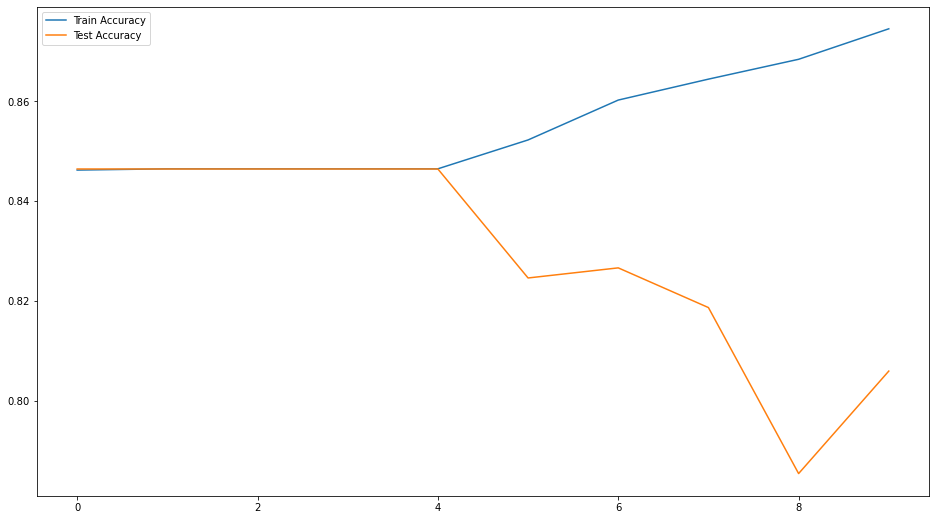

In [168]:
plt.figure(figsize=(16,9))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend();

In [169]:
#train accuracy score
model.evaluate(X_train_padded, y_train, verbose=0)[1]

0.877186

In [170]:
#test accuracy score
model.evaluate(X_val_padded, y_validate, verbose=0)[1]

0.8058968

In [171]:
# prediction of gs4 model on test data
predict_lstm = (model.predict(X_val_padded)> 0.5).astype(int)

In [172]:
# confusion matrix
confusion_matrix(predict_lstm, y_validate)

array([[5483,  970],
       [ 373,   93]], dtype=int64)

In [173]:
tn, fp, fn, tp = confusion_matrix(predict_lstm, y_validate).ravel()

In [174]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 5483
False Positives: 970
False Negatives: 373
True Positives: 93


In [175]:
pred_proba = predict_lstm.ravel()

pred_df = pd.DataFrame({'validate_values': y_validate['target'],
                        'pred_probs':pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0
29198,0,0
26550,0,0
30124,0,0
2557,0,0


In [176]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.087
Sensitivity of gs1 is: 0.2
F1 score of gs1 is: 0.122
ROC AUC of gs1 is: 0.512


## Modeling summary

In [177]:
# Summary of Model scores in Dataframe
summary_df = pd.DataFrame({'accuracy(train)' : [0.661,0.600,0.999,0.992,0.877],
                           'accuracy(val)':  [0.665,0.591,0.905,0.895,0.806],
                           'precision' :   [0.331,0.455,0.462,0.401,0.087],
                           'sensitivity' :     [0.18,0.177,0.854,0.83,0.2],
                           'F1' :            [0.233,0.255,0.600,0.541,0.122],
                           'roc_auc' :       [0.547,0.552,0.925,0.908,0.512]})
# Transpose dataframe
summary_dft = summary_df.T
# Rename columns
summary_dft.columns = ['gs1 (cvec->Ls)', 'gs2 (tfidf->Ls)', 'gs3 (cvec->XGB)', 'gs4 (tfidf->XGB)', 'gs6 (Bilateral LSTM)']
summary_dft

,gs1 (cvec->Ls),gs2 (tfidf->Ls),gs3 (cvec->XGB),gs4 (tfidf->XGB),gs6 (Bilateral LSTM)
accuracy(train),0.661,0.600,0.999,0.992,0.877
accuracy(val),0.665,0.591,0.905,0.895,0.806
precision,0.331,0.455,0.462,0.401,0.087
sensitivity,0.180,0.177,0.854,0.830,0.200
F1,0.233,0.255,0.600,0.541,0.122
roc_auc,0.547,0.552,0.925,0.908,0.512


# Best model perfromance on the holdout dataset
The best model chosen would be gs3 cvec, XGB based on accuracy and sensitivity

In [60]:
#Training data
X_train_validate = pd.concat([X_train,X_validate])
y_train_validate = pd.concat([y_train,y_validate])

In [61]:
# loading holdout dataset
X_holdout = pd.read_csv('./datasets/X_holdout.csv', index_col=0)
y_holdout = pd.read_csv('./datasets/y_holdout.csv', index_col=0)

In [62]:
Best_params = {'cvec__max_df': 0.85, 'cvec__max_features': 75, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}

In [63]:
#Instantiating the CVEC with the best params
cvec= CountVectorizer(max_df = 0.85,
                     max_features = 75,
                     min_df = 2,
                     ngram_range = (1, 2))

#transforming the sparse matrix into a dataframe and merging it back
train_sparse = pd.DataFrame(cvec.fit_transform(X_train_validate['cleaned_tweets']).todense(),
                            index=X_train_validate.index, 
                            columns=cvec.get_feature_names())

holdout_sparse = pd.DataFrame(cvec.transform(X_holdout['cleaned_tweets']).todense(), 
                               index=X_holdout.index,
                               columns=cvec.get_feature_names())

#Final dataframe for modelling
X_train_cvec = X_train_validate.drop(['cleaned_tweets'], axis=1).join(train_sparse)
X_holdout_cvec = X_holdout.drop(['cleaned_tweets'], axis=1).join(holdout_sparse)

In [64]:
gs_best = gs3.best_estimator_

gs_best = GridSearchCV(pipe_xgb,pipe_xgb_params,cv=10,verbose=1)
gs_best.fit(X_train_cvec, np.ravel(y_train_validate))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.3min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('ss', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                

In [65]:
# gs_best score of training data
gs_best.score(X_train_cvec, y_train_validate)

0.9980054921231392

In [66]:
# gs_best score of validation data
gs_best.score(X_holdout_cvec, y_holdout)

0.9064631749335184

In [67]:
# prediction of gs_best model on test data
predict_best = gs_best.predict(X_holdout_cvec)

In [68]:
# confusion matrix
confusion_matrix(predict_best, y_holdout)

array([[7217,  705],
       [ 104,  623]], dtype=int64)

In [69]:
tn, fp, fn, tp = confusion_matrix(predict_best, y_holdout).ravel()

In [70]:
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 7217
False Positives: 705
False Negatives: 104
True Positives: 623


In [181]:
holdout_pred_proba = [i[1] for i in gs_best.predict_proba(X_holdout_cvec)]

holdout_pred_df = pd.DataFrame({'true_values': y_holdout['target'],
                        'pred_probs':holdout_pred_proba})
pred_df.head()

,validate_values,pred_probs
10006,0,0
29198,0,0
26550,0,0
30124,0,0
2557,0,0


In [72]:
# calculating precision, sensitivty and F1 score
Precision = tp/(tp+fp)
Sensitivity = tp/(tp+fn)
f1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)

# Calculate ROC AUC.
roc_auc = roc_auc_score(pred_df['validate_values'], pred_df['pred_probs'])

print('Precision of gs1 is: %s' % round(Precision,3))
print('Sensitivity of gs1 is: %s' % round(Sensitivity,3))
print('F1 score of gs1 is: %s' % round(f1,3))
print('ROC AUC of gs1 is: %s' % round(roc_auc,3))

Precision of gs1 is: 0.469
Sensitivity of gs1 is: 0.857
F1 score of gs1 is: 0.606
ROC AUC of gs1 is: 0.925


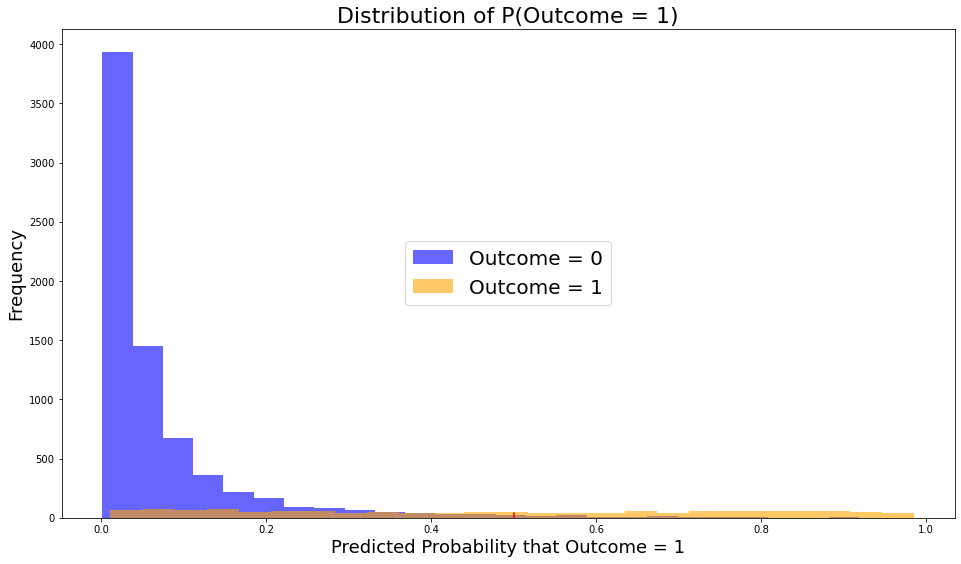

In [182]:
# Create figure.
plt.figure(figsize = (16,9))

# Create two histograms of observations.
plt.hist(holdout_pred_df[holdout_pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(holdout_pred_df[holdout_pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')


# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20, loc='center');

The model is able to accuractely predict with a high degree of certainty the negative class outcome, however, it is unable to perform as well on the positive class.

In [183]:
# Calculate ROC AUC.
roc_auc_score(holdout_pred_df['true_values'], holdout_pred_df['pred_probs'])

0.9247569090732551

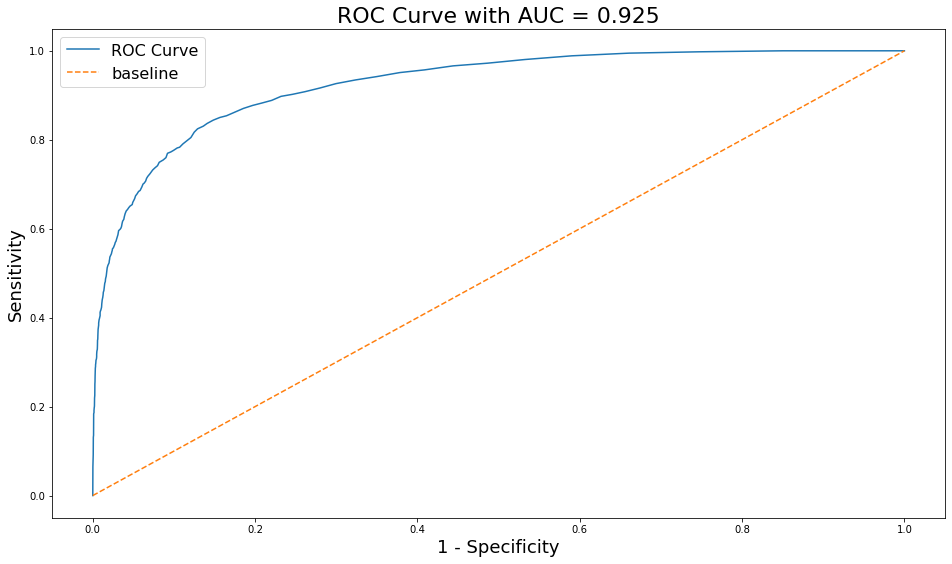

In [184]:
# Create figure.
plt.figure(figsize = (16,9))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(holdout_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(holdout_pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(holdout_pred_df["true_values"], holdout_pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

## Summary of performance

In [178]:
summary_dft['best_model (cvecc->xgboost)'] = [0.998,0.906,0.469,0.857, 0.606, 0.925]
summary_dft

,gs1 (cvec->Ls),gs2 (tfidf->Ls),gs3 (cvec->XGB),gs4 (tfidf->XGB),gs6 (Bilateral LSTM),best_model (cvecc->xgboost)
accuracy(train),0.661,0.600,0.999,0.992,0.877,0.998
accuracy(val),0.665,0.591,0.905,0.895,0.806,0.906
precision,0.331,0.455,0.462,0.401,0.087,0.469
sensitivity,0.180,0.177,0.854,0.830,0.200,0.857
F1,0.233,0.255,0.600,0.541,0.122,0.606
roc_auc,0.547,0.552,0.925,0.908,0.512,0.925


## Map of tree

In [73]:
model_xgb = XGBClassifier(colsample_bytree = 1,
                      gamma = 0.5,
                      learning_rate = 0.1,
                      max_depth = 13,
                      min_child_weight = 1,
                      n_estimators = 100,
                      objective ='binary:logistic',
                      random_state= 42,
                      subsample = 1)

In [74]:
model_xgb.fit(X_train_cvec, np.ravel(y_train_validate))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
# credit to user Eftim 
# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python

def plot_tree_function(model_xgb, filename, rankdir='LR'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    gvz = xgb.to_graphviz(model_xgb, num_trees=0, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [88]:
#saves the pdf file
plot_tree_function(model_xgb, 'xgboost_test_tree.pdf')

## Misclassified reviews in the holdout dataset

In [76]:
X_holdout['target'] = y_holdout
X_holdout['predicted'] = predict_best

In [77]:
X_holdout.head()

,retweets,favorites,cleaned_tweets,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,min_sin,min_cos,time_to_open,time_after_close,potus_status,vader_negative,vader_neutral,vader_positive,vader_compound,negative_word,positive_word,uncertainty_word,litigious_word,constraining_word,interesting_word,modal_strong_word,modal_neutral_word,modal_weak_word,string_count,word_count,unique_words_count,target,predicted
29145,4550,16531,i have raised given a tremendous amount of money to our great veteran and have got nothing but bad publicity for doing so watch,5.000000e-01,-0.866025,-2.449294e-16,1.000000,1.000000,6.123234e-17,-9.510565e-01,-0.309017,10060.0,0.0,0,0.000,0.760,0.240,0.7661,1,2,0,0,0,0,0,0,0,127,24,24,0,0
16282,18,32,via dallasnews neighborsgo by heather noel shelton school graduate receives handwritten note from donald trump,-5.000000e-01,-0.866025,9.884683e-01,0.151428,-0.500000,-8.660254e-01,9.510565e-01,0.309017,0.0,0.0,0,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,0,0,0,110,15,15,0,0
33332,29123,127446,the democrat have been told and fully understand that there can be no daca without the desperately needed wall at the southern border and an end to the horrible chain migration ridiculous lottery system of immigration etc we must protect our country at all cost,-2.449294e-16,1.000000,-3.943559e-01,0.918958,0.965926,-2.588190e-01,9.945219e-01,-0.104528,8029.0,0.0,1,0.156,0.755,0.088,-0.5730,0,0,0,0,0,0,1,1,0,261,45,45,0,0
6590,143,59,great to see yankee captain derek jeter back on the field he will have another great season and make nyc proud again,8.660254e-01,0.500000,-6.513725e-01,-0.758758,0.258819,-9.659258e-01,-9.135455e-01,0.406737,0.0,0.0,0,0.000,0.639,0.361,0.9062,0,2,0,0,0,0,1,0,0,116,22,22,0,0
17792,37,65,bagholders realdonaldtrump trump president close the boarder and protect our child,-8.660254e-01,0.500000,4.853020e-01,-0.874347,1.000000,6.123234e-17,1.224647e-16,-1.000000,10783.0,0.0,0,0.000,0.790,0.210,0.4912,0,0,0,0,0,0,0,0,0,82,11,11,1,0


In [78]:
X_holdout[(X_holdout['target']==1) & (X_holdout['predicted']==0)][['cleaned_tweets', 'vader_compound']]

,cleaned_tweets,vader_compound
17792,bagholders realdonaldtrump trump president close the boarder and protect our child,0.4912
29382,darrenwaggener realdonaldtrump what ha happened in the uk in the last hour is exactly what will happen in november vote trump,0.0000
35779,there is great anger in our country caused in part by inaccurate and even fraudulent reporting of the news the fake news medium the true enemy of the people must stop the open obvious hostility report the news accurately fairly that will do much to put out the flame,-0.9062
695,doe barackobama ever work he is constantly campaigning and fundraising on both the taxpayer s dime and time not fair,0.3802
41959,approval rating in the republican party overall not bad considering i get nothing but fake corrupt news day and night russia russia russia then the ukraine scam where s the whistleblower the impeachment hoax and more more more,0.2746
33739,spoke to pm turnbullmalcolm of australia he is committed to having a very fair and reciprocal military and trade relationship working very quickly on a security agreement so we don t have to impose steel or aluminum tariff on our ally the great nation of australia,0.9097
9890,excited and honored to be addressing thefamilyleader summit in iowa this august,0.7351
28923,if the people of massachusetts found out what an ineffective senator goofy elizabeth warren ha been she would lose,-0.5411
10750,fed obama need to listen to realdonaldtrump so we can turn thing around economically so true and it would be sooooo easy,0.8122
42361,great new book just out by the former director of ice tom homan defend the border and save life solving our most important humanitarian and security crisis great guy get your copy today pic twitter com zgaqbhosp,0.9558


# Conclusion

The best model to use would be Countvectorizer into XGBoost, with an accuracy of 0.906 on the holdout dataset.
The best hyperparameters:
- 'cvec__max_df': 0.85, 
- 'cvec__max_features': 75, 
- 'cvec__min_df': 2, 
- 'cvec__ngram_range': (1, 2),
- 'smote__k_neighbors': 5,
- 'smote__sampling_strategy': 'minority',
- 'xgb__colsample_bytree': 1.0,
- 'xgb__gamma': 0.5,
- 'xgb__learning_rate': 0.1,
- 'xgb__max_depth': 13,
- 'xgb__min_child_weight': 1,
- 'xgb__n_estimators': 100,
- 'xgb__objective': 'binary:logistic',
- 'xgb__random_state': 42,
- xgb__subsample': 1.0}

## Limitations

However, the model suffers in terms of precision, correctly predicitng the positive class as the posivite class. More work needs to be done on:
- XGBoost being non-parametric plus the features i engineered are not readable to the lay person
- Feature engineering, a tweet after closing could impact the following day's one.
- Collection of more data on the positive class, or even change the parameters of a positive class
- Try additional an ensemble of machine learning models
- Feed the whole feature set into the neural network
- More work can be done on the LSTM model,from optimisation of hyperparameters to including a timeseries generator
- Additional work can be further done on the topic modelling

## Recommendation to the US market team at the bank
- On days of positive class, Trump tends to tweet more on average
- The model is able to accurately predict when his tweets will not move the market